In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import ttest_ind
import pickle

from numpy import median

df = pd.read_csv('data/preprocessed.csv')
df['run_index'] = [i for i in range(len(df))]
df = df.drop(columns=['Unnamed: 0'])

In [2]:
# Rescreen Column remapping
remap_dict = {'amylase_2_10x': 'amylase_10x',
              'amylase_1_10x': 'amylase_10x',
              'positive_amy_10x': 'amylase_10x',
              'positive_xyl_50x': 'xylanase_50x',
              'xylanase_1_50x': 'xylanase_50x'}
df['family'].replace(remap_dict, inplace=True)
df['mean_assay'] = df[['assay_1_value', 'assay_2_value', 
                       'assay_3_value', 'assay_4_value', 
                       'assay_5_value', ]].mean(skipna=True, axis=1)

In [3]:
# Create new 'correct' column based on results from pairwise alignments, which found more SPs
def combine_cols(row):
    if row["prot_correct"] == True and row["sp_correct"] == True:
        return True
    else:
        return False
    
df['old_correct'] = df['correct'].values
df['correct'] = df.apply(lambda x: combine_cols(x), axis=1)
df = df[df['correct'] == True]

In [4]:
# Create 'run_type' column to distinguish between positive/negative controls and generated data
def pos_neg_id(row):
    if row['run_id'][-3:] == 'pos':
        return 'pos'
    elif row['run_id'][-3:] == 'neg':
        return 'neg'
    else:
        return 'gen'
    
df['run_type'] = df.apply(lambda x: pos_neg_id(x), axis=1)
df

,assay_1_value,assay_2_value,assay_3_value,assay_4_value,assay_5_value,correct,protein_id,sp_id,run_label,sp_correct,prot_correct,true_prot_id,family,run_id,run_index,mean_assay,old_correct,run_type
0,0.384,0.228,0.404,0.394,NaN,True,Arnold_003,sps33-2,amylase_1,True,True,seq33,amylase,33_33-2,0,0.352500,True,gen
1,2.496,2.820,2.148,2.134,NaN,True,Arnold_003,sps13-3,amylase_1,True,True,seq33,amylase,33_13-3,1,2.399500,True,gen
2,0.360,0.320,0.278,0.296,NaN,True,Arnold_003,sps9-3,amylase_1,True,True,seq33,amylase,33_9-3,2,0.313500,True,gen
3,0.338,0.468,0.330,0.352,NaN,True,Arnold_001,sps20-2,amylase_1,True,True,seq39,amylase,39_20-2,3,0.372000,True,gen
4,0.280,0.386,0.304,0.662,NaN,True,Arnold_006,sps20-4,amylase_1,True,True,seq40,amylase,40_20-4,4,0.408000,True,gen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,0.752,0.524,0.736,NaN,NaN,True,Arnold_040,Neg1,negative,True,True,seq26,negative,26_1_neg,1154,0.670667,True,neg
1155,0.860,0.892,0.672,NaN,NaN,True,Arnold_040,Neg1,negative,True,True,seq26,negative,26_1_neg,1155,0.808000,True,neg
1156,1.452,1.782,1.640,NaN,NaN,True,Arnold_040,Neg3,negative,True,True,seq26,negative,26_3_neg,1156,1.624667,True,neg
1157,0.574,0.644,0.622,NaN,NaN,True,Arnold_040,Neg1,negative,True,True,seq26,negative,26_1_neg,1157,0.613333,True,neg


In [5]:
df_functional = pd.read_csv("data/func_class_p0.05_effectsize2.0_functional.csv")
func_prots = list(set(df_functional['seqID'].values))
print(func_prots, len(func_prots))

['seq19', 'seq5', 'seq21', 'seq25', 'seq33', 'seq1', 'seq39', 'seq3', 'seq36', 'seq26'] 10


In [6]:
true_prot_ids = list(set(df['true_prot_id'].values))

In [7]:
title_color_dict = {'xylanase':'red',
                    'lipase':'blue',
                    'amylase':'green',
                    'protease':'orange'}

In [8]:
import pickle
seq2newid2 = pickle.load(open("data/final_plot_ids_2.p", "rb"))

with open('data/final_sp_plot_dict.p','rb') as f:
    sp_plot_id = pickle.load(f)

def get_new_id(row, include_prot=False):
    if row['run_id'] == 'false_construct':
        return 'incorrect construct'
    
    else:
        old_id = row['run_id'].split('_')

        if len(old_id) == 3: # then it's a control
            prot, sp, _ = old_id

            if old_id[-1] == 'neg':
                new_id = 'random_' + sp
            elif old_id[-1] == 'pos':
                try:
                    new_id = seq2newid2[sp]
                except KeyError:
                    new_id = 'incorrect construct pos'
    #                 print(old_id)
            else:
                raise ImplementationError

        elif len(old_id) == 2:
#             prot, sp = old_id
#             sp_ref, sp_num = sp.split('-')
#             new_id = seq2newid2[sp_ref] + '-' + sp_num
            new_id = sp_plot_id[row['sp_id']]
            
        else:
            raise ImplementationError

        if include_prot:
            new_id = seq2newid2[prot] + '_' + new_id

        return new_id

In [9]:
df.columns

Index(['assay_1_value', 'assay_2_value', 'assay_3_value', 'assay_4_value',
       'assay_5_value', 'correct', 'protein_id', 'sp_id', 'run_label',
       'sp_correct', 'prot_correct', 'true_prot_id', 'family', 'run_id',
       'run_index', 'mean_assay', 'old_correct', 'run_type'],
      dtype='object')

seq19 had no sequences
seq5 had no sequences
seq36 had no sequences


<Figure size 432x288 with 0 Axes>

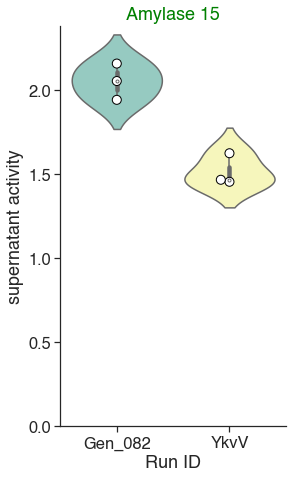

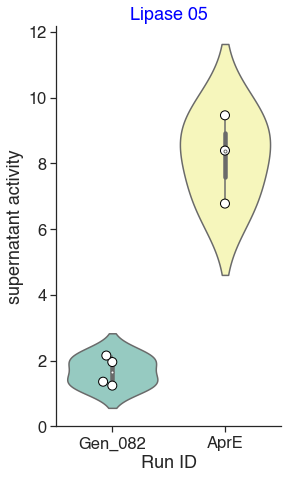

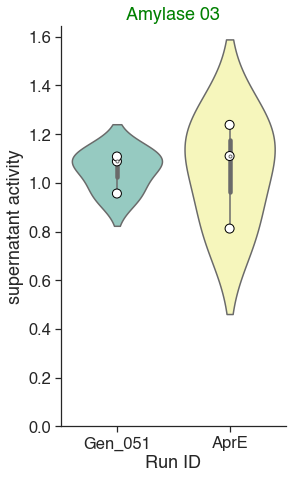

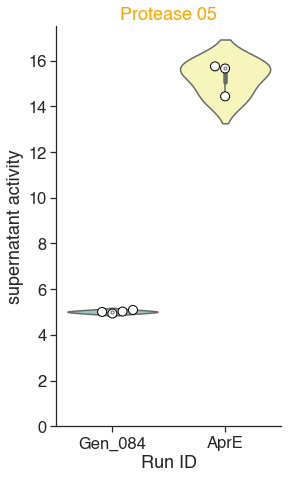

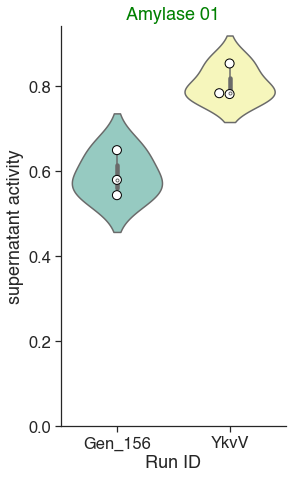

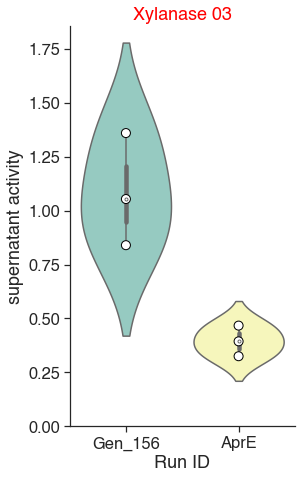

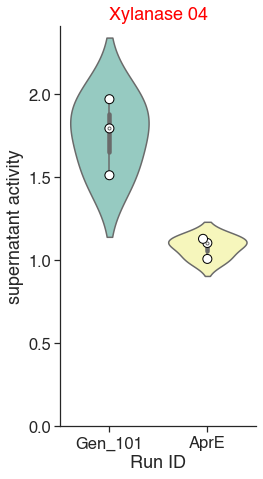

In [10]:
sns.set_context('notebook', font_scale=1.4)
sns.set(font='helvetica', context='notebook', font_scale=1.3, style='ticks')
sns.despine()

# For each functional protein
# prot = func_prots[0]
for prot in func_prots:
    # Select stuff
    _df = df[df['true_prot_id'] == prot].copy()
    prot_family = _df['run_label'].iloc[0].split('_')[0]

    # Check if there's higher dilution assay
    fams_covered = list(set(_df['family'].values))
    higher_dilution_fam = ''
    fold_x = ''
    for fam in fams_covered:
        if fam[-2:] == '0x':
            fold_x = fam[-3:]
            higher_dilution_fam = fam
#     print(higher_dilution_fam)
    # If yes, only look at that one, otherwise carry on
    if higher_dilution_fam != '':
        _df = _df[_df['family'] == higher_dilution_fam]

    # Get run_id of highest negative, family member, and positive control
    plot_df = pd.DataFrame()
    for run_type in ['gen', 'pos']: #, 'neg'
        _subdf = _df[_df['run_type'] == run_type]
        if len(_subdf) > 0:  
            maxid = _subdf['mean_assay'].values.argmax()
            max_subdf = _subdf.iloc[maxid]
            plot_df = plot_df.append(max_subdf, ignore_index=True, sort=False)

    if len(plot_df) > 1:
        # PLOTTING
        # Plot 3 data by run_id
        cols = list(plot_df.columns)
        value_vars = ['assay_' + str(i) + '_value' for i in range(1, 6)]
        for col_name in value_vars:
            cols.remove(col_name)
        melted_df = pd.melt(plot_df, id_vars=cols, value_vars=value_vars, value_name = 'assay_value')
        melted_df['plot_id'] = melted_df.apply(lambda row: get_new_id(row), axis=1)
        plt.gcf().subplots_adjust(left=0.15)
        sns.set(font='helvetica', context='notebook', font_scale=1.5, style='ticks')
        sns.set_palette(sns.color_palette("Set3"))
        
        fig = plt.figure(figsize=(4,7))
        g = sns.swarmplot(data=melted_df, x='plot_id', y='assay_value',  color='white', size=9, edgecolor='black', linewidth=1)
        g = sns.violinplot(data=melted_df, x='plot_id', y='assay_value', hue='run_type', dodge=False)
        
        title_code = seq2newid2[prot[3:]]
        prot_code, prot_id = title_code.split('_')
        prot_title_dict = {'Amy':'Amylase', 'Pro':'Protease', 'Lip':'Lipase', 'Xyl':'Xylanase'}
        title = prot_title_dict[prot_code] + ' ' + prot_id

        g.axes.set_title(title, color=title_color_dict[prot_family])
        g.set(ylim=(0,None))
        
        plt.tight_layout()
        g.set(ylabel = 'supernatant activity')
        g.set(xlabel = 'Run ID')
        plt.legend(loc='upper right')
        
#         g.set(ylabel = '  ')
        g.get_legend().remove()
        sns.despine()
        
        fig.savefig('data/figs/top_func_compar/' + prot + '_' + prot_family + '.svg')
        
    else:
        print(prot, 'had no sequences')

In [11]:
plot_df

,assay_1_value,assay_2_value,assay_3_value,assay_4_value,assay_5_value,correct,family,mean_assay,old_correct,prot_correct,protein_id,run_id,run_index,run_label,run_type,sp_correct,sp_id,true_prot_id
0,1.794,1.970,1.512,NaN,NaN,1.0,xylanase_50x,1.758667,True,1.0,Arnold_040,26_26-1,660.0,xylanase_1_50x,gen,1.0,sps26-1,seq26
1,1.008,1.129,1.104,NaN,NaN,1.0,xylanase_50x,1.080333,True,1.0,Arnold_040,26_003_pos,1088.0,positive_xyl_50x,pos,1.0,Sig003,seq26


In [12]:
markers = {"gen": "s", "pos": "^", "neg": "v"}

<Figure size 288x144 with 0 Axes>

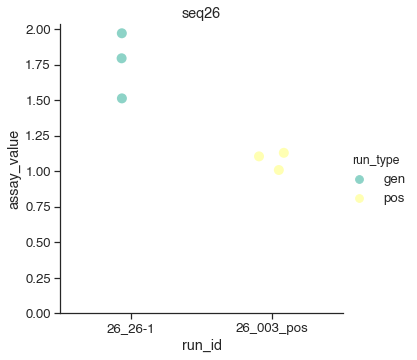

In [13]:
cols = list(plot_df.columns)
value_vars = ['assay_' + str(i) + '_value' for i in range(1, 6)]
for col_name in value_vars:
    cols.remove(col_name)
melted_df = pd.melt(plot_df, id_vars=cols, value_vars=value_vars, value_name = 'assay_value')

sns.set_context('notebook', font_scale=1.2)
fig = plt.figure(figsize=(4,2))
g = sns.catplot(data=melted_df, x='run_id', y='assay_value', hue='run_type', s=10)

g.set(title=prot)
g.set(ylim=(0,None))

<Figure size 288x144 with 0 Axes>

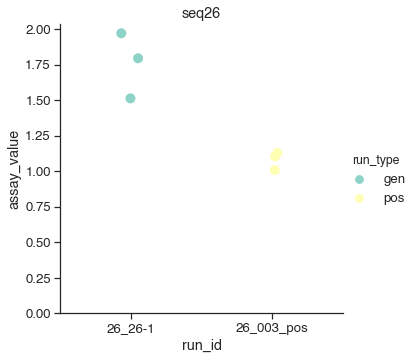

In [14]:
sns.set_context('notebook', font_scale=1.2)
fig = plt.figure(figsize=(4,2))
g = sns.catplot(data=melted_df, x='run_id', y='assay_value', hue='run_type', s=10)

g.set(title=prot)
g.set(ylim=(0,None))

In [15]:
# might need this later

In [16]:
# Need list of proteins for each family
enzyme_order_df = pd.read_excel("data/initial_enzymes_1.xlsx")
sp_df = pd.read_excel("data/sp_prot_translations.xls")

# Map true protein ids
enzyme_order_df['prot_seq_trunc'] = enzyme_order_df['Protein-met-sigp'].str[:80]
sp_df['prot_seq_trunc'] = sp_df['prot_seq'].str[1:81]
merge_df = enzyme_order_df.merge(sp_df, how='inner', on='prot_seq_trunc')

merge_df[['enzyme_id','enzyme_type','seqID']]

# Get shuffled enzyme ID list back out
enzIDkeydf = merge_df[['enzyme_id','enzyme_type','seqID']]

In [17]:
seq2enzyme = pd.Series(enzIDkeydf.enzyme_id.values, index= enzIDkeydf.seqID).to_dict()
seq2family = pd.Series(enzIDkeydf.enzyme_type.values, index= enzIDkeydf.seqID).to_dict()